Duygu Nur Arabaci Homework 2

Problem 1

In [1]:
def problem1(directory):
    """
    finds the top-4 features having the highest relationship 
    with the target ("calories burned" column) using mutual information score.
    finds top-4 feature combination Using Recursive Feature Elimination method with Ridge regressor.
    
    Parameters: 

    directory(str): the folder to search for the file
    """
    #formatting pathing
    from pathlib import Path
    directory = Path(directory)
    
    import pandas as pd
    import numpy as np
    from sklearn.feature_selection import mutual_info_regression,SelectKBest,RFE
    from sklearn.linear_model import Ridge

    #read in the data and define "," as thousand separator, 
    #drop date column and get the columns in appropriate variables as float types
    data=pd.read_csv(directory, thousands = ",")
    data = data.drop("Date", axis=1)
    target = data["Calories Burned"].astype(float)
    features=data.iloc[:,1:]
    #define the mutual information score as select k best method and apply for top 4 and apply
    MIR=SelectKBest(score_func=mutual_info_regression,k=4)
    top4=MIR.fit(features,target)
    #indices of sorted scores, in reverse
    indices=np.argsort(top4.scores_)[::-1]
    print("Selected features having top mutual information scores")
    a=np.array(features.columns)[indices]
    print(a[:4])
    #Recursive Feature Elimination
    #model is defined as ridge regression, and top 4 features are to be selected. It is then applied
    model=Ridge()
    rfe=RFE(model,4)
    rfe_selection=rfe.fit(features,target)
    rfe_selection.ranking_
    rfe_features=np.array(features.columns)[rfe_selection.support_]
    print("Selected features by Recursive Feature Elimination")
    print(rfe_features)

In [2]:
problem1("homewor2-data/fitbit.csv")

Selected features having top mutual information scores
['Activity Calories' 'Minutes Fairly Active' 'Steps' 'Distance']
Selected features by Recursive Feature Elimination
['Distance' 'Minutes Lightly Active' 'Minutes Fairly Active'
 'Minutes Very Active']


Problem 2

In [17]:
def problem2(directory):
    """
    Produces Elbow and silhouette coefficient plots for cluster numbers ranging from 2 to 9 with standard scaling.
    
    Parameters: 

    directory(str): the folder to search for the file
    """
    
    #formatting pathing
    from pathlib import Path
    directory = Path(directory)

    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import matplotlib.pyplot as plt
    import numpy as np
    #read in the data and drop ID column
    cust=pd.read_csv(directory)
    cust = cust.drop("ID", axis=1)
    
    #normalize the data
    scaler=StandardScaler()
    cust_scaled=scaler.fit_transform(cust)
    #make clusters ranging from 2 to 9
    inertia_list_scaled=[]
    silhouette_score_list_scaled=[]
    for i in range(2,10):
        k_means=KMeans(n_clusters=i,n_init=5)
        k_means.fit(cust_scaled)
        inertia_list_scaled.append(k_means.inertia_)
        silhouette_score_list_scaled.append(silhouette_score(cust_scaled,k_means.labels_))
    
    cluster_numbers=np.arange(2,10)
    #plot the data
    plt.plot(cluster_numbers,inertia_list_scaled,"o-")
    plt.grid(True)
    plt.xlabel("Cluster Number")
    plt.ylabel("Inertia or Distortion")
    plt.title("Elbow method")
    plt.savefig("Elbow_method.png")
    plt.show()

    plt.plot(cluster_numbers,silhouette_score_list_scaled,"o-")
    plt.xlabel("Cluster number")
    plt.ylabel("Silhouette_Score")
    plt.title("silhouette_Method")
    plt.grid(True)
    plt.savefig("silhouette.png")
    plt.show()

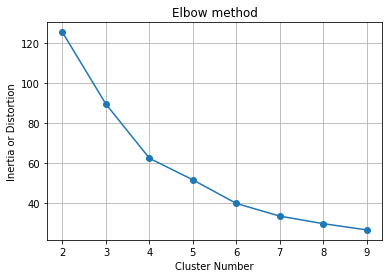

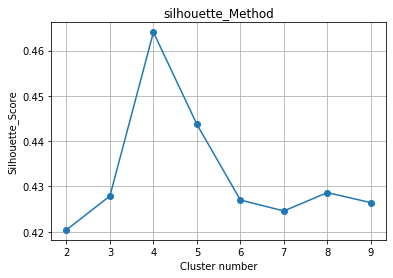

In [18]:
problem2("homewor2-data/customer.csv")

Problem 3

In [23]:
def problem3(directory):
    """
    Predicts customer churn with Logistic Regression, Decision Tree, Support Vector Machine, K-Nearest
    Neighbor and Neural Network methods using default sklearn parameters.
    Prints the average accuracy scores for training and test splits of shuffled 5-Fold cross validation
    
    Parameters: 

    directory(str): the folder to search for the file
    """
    from sklearn.svm import LinearSVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model.logistic import LogisticRegression
    from sklearn.metrics import classification_report
    from sklearn.preprocessing import Normalizer, OneHotEncoder
    from sklearn.model_selection import train_test_split,cross_val_score,KFold
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.compose import ColumnTransformer
    import pandas as pd
    import numpy as np
    
    #formatting pathing
    from pathlib import Path
    directory = Path(directory)

    #read in data with assigning na to blank spaces, and drop associated rows, as well as the customer ID column
    raw_data=pd.read_csv(directory,na_values=[" ", ""]).dropna()
    data=raw_data.drop("customerID", axis=1)
    
    #define the numeric and categorical columns and transform the categorical and scale the numerical
    cat_columns= data.drop(["tenure","MonthlyCharges", "TotalCharges", "Churn"], axis=1).columns
    num_columns=["tenure","MonthlyCharges", "TotalCharges"]
    #used normalizer as scaler because it gives the most accurate results for MLP 
    #while it doesnt cause a significant change in others
    scaler= Normalizer()
    #transform the categorical data using one hot encoder and use standard scaler to normalize the numerical columns
    transformer=ColumnTransformer([("dummy",OneHotEncoder(),cat_columns),("normalizer",scaler,num_columns)])
    data_scaled=transformer.fit_transform(data)
    a_data=transformer.fit_transform(data)
    #change the churn column from yes and no to 0 and 1
    raw_data["Churn"]=raw_data.Churn.map(lambda x: 1 if "Yes" in x else 0)
    
    data_scaled=scaler.fit_transform(a_data)
    X=data_scaled
    y=raw_data["Churn"]
    
    #apply different models after splitting data into test and train and cross validate with kfold 5 times with shuffling
    X_train,X_test,y_train,y_test=train_test_split(data_scaled,y,shuffle=True)
    knn=KNeighborsClassifier()
    knn.fit(X_train,y_train)
    kf=KFold(n_splits=5,shuffle=True)
    scores=cross_val_score(knn,X,y,cv=kf,scoring='accuracy')
    
    models=[LogisticRegression(), DecisionTreeClassifier(), LinearSVC(), KNeighborsClassifier(), MLPClassifier()]
    models_string=["LogisticRegression", "DecisionTree", "LinearSVC", "KNN", "MLPClassifier"]

    def scores_calc(model, X, y, trains, kfold):
        """
        Calculates average accuracy scores for training and test splits of cross validation
        Parameters:
            model : function that implements fit and score
            X : scaled data
            y : values
            trains : train data in form (X_train, y_train)
            kfold : KFold value
        Returns : tuple of form (<training scores>, <test scores>)
        """
        model.fit(trains[0],trains[1])
        test_scores = cross_val_score(model,X,y,cv=kf,scoring='accuracy').mean()
        training_scores = model.score(trains[0],trains[1])
        return((training_scores,test_scores))
    
    rows = []
    i = 0
    for model in models:
        scores = scores_calc(model, X, y, (X_train, y_train), kf)
        rows.append([models_string[i], scores[0], scores[1]])
        i += 1
    df = pd.DataFrame(np.array(rows), columns=["model", "train", "test"])
    display(df)

In [24]:
problem3("homewor2-data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

C:\Users\Lyra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lyra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lyra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lyra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lyra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

,model,train,test
0,LogisticRegression,0.7974971558589306,0.7986345452174203
1,DecisionTree,0.9977246871444824,0.7235473718584481
2,LinearSVC,0.7993932499051953,0.7973546209209995
3,KNN,0.8282138794084186,0.759242094748772
4,MLPClassifier,0.8139931740614335,0.7872573729604365
